In [11]:
%matplotlib inline
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from tools import utils
from data import goes16s3

import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import os
from PIL import Image

import torch

import cv2

In [2]:
dayofyear = 283
year = 2018
n_channels = 3

figure_directory = 'figures/network-architecture/'
if not os.path.exists(figure_directory):
    os.makedirs(figure_directory)

In [3]:
noaa = goes16s3.NOAAGOESS3(channels=range(1,n_channels+1), 
                           product='ABI-L1b-RadC',
                           save_directory='../data/GOES/')
#noaa.download_day(year, dayofyear)
files = noaa.local_files()

I0files = files.loc[year, dayofyear, 18, 2].values[0,:n_channels]
I1files = files.loc[year, dayofyear, 18, 2+15].values[0,:n_channels]

print(I1files)

I0 = goes16s3._open_and_merge_2km(I0files)
I1 = goes16s3._open_and_merge_2km(I1files)

['../data/GOES/ABI-L1b-RadC/OR_ABI-L1b-RadC-M3C01_G16_s20182831817203_e20182831819576_c20182831820019.nc'
 '../data/GOES/ABI-L1b-RadC/OR_ABI-L1b-RadC-M3C02_G16_s20182831817203_e20182831819576_c20182831820017.nc'
 '../data/GOES/ABI-L1b-RadC/OR_ABI-L1b-RadC-M3C03_G16_s20182831817203_e20182831819576_c20182831820023.nc']


In [20]:
def plot_3channel_image(x, img_file=None):
    x_img = x.detach().numpy()[0][[1,2,0]]
    x_img = np.transpose(x_img, (1,2,0))
    if img_file is not None:
        plt.imsave(img_file, x_img)
        
    plt.imshow(x_img)
    plt.axis('off')
    plt.show()
    
def plot_1channel_image(x, img_file=None, cmap=None, vmin=None, vmax=None):
    x_img = x.detach().numpy()[0,0]
    if img_file is not None:
        plt.imsave(img_file, x_img, cmap=cmap, vmin=vmin, vmax=vmax)
        
    plt.imshow(x_img, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.show()

def plot_2channel_image(x, img_file=None):
    img1 = x.detach().numpy()[0,0]
    img2 = x.detach().numpy()[0,1]
    
    img = np.concatenate([img1, img2], axis=1)
    if img_file is not None:
        plt.imsave(img_file, img)
        
        
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    


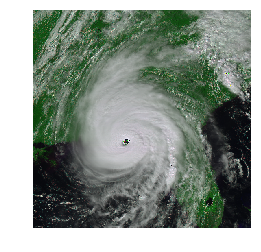

In [5]:
#I0_sub = I0.sel(x=slice(-0.05,0.01), y=slice(0.12,0.06))
#I1_sub = I1.sel(x=slice(-0.05,0.01), y=slice(0.12,0.06))

I0_sub = I0.sel(x=slice(-0.04,-0.01), y=slice(0.105,0.075))
I1_sub = I1.sel(x=slice(-0.04,-0.01), y=slice(0.105,0.075))



rgb = np.transpose(I0_sub.values[[1,2,0]], (1,2,0))
plt.imshow(rgb, vmin=0.0, vmax=1.)

plt.axis('off')
plt.show()

In [6]:
from tools import inference_tools

model_path = '../save-models/'# % n_channels
flownet, interpnet, warper = inference_tools.load_models(n_channels, model_path, False)

cpu
loading checkpoint ../save-models/checkpoint.flownet.pth.tar
=> loaded checkpoint '../save-models/checkpoint.flownet.pth.tar' (epoch 19)


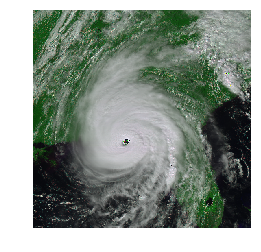

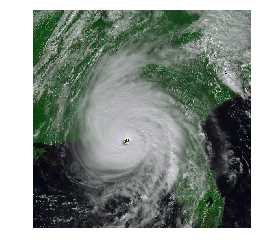

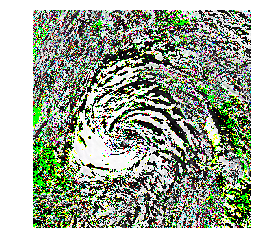

torch.Size([1, 4, 536, 536])


In [17]:
I0_torch = torch.from_numpy(I0_sub.values[np.newaxis])
I1_torch = torch.from_numpy(I1_sub.values[np.newaxis])

plot_3channel_image(I0_torch, os.path.join(figure_directory, 'I0.png'))
plot_3channel_image(I1_torch, os.path.join(figure_directory, 'I1.png'))
plot_3channel_image(I1_torch-I0_torch, os.path.join(figure_directory, 'I1-minus-I0.png'))

f = flownet(I0_torch, I1_torch)
n_channels = I0_sub.shape[1]

f_01 = f[:,:2]
f_10 = f[:,2:]
print(f.shape)

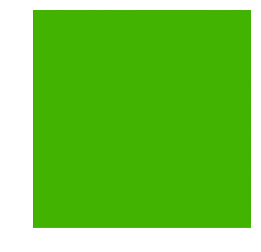

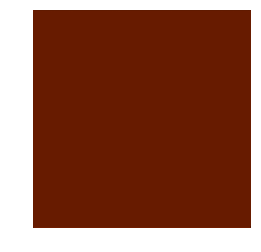

(array([287296,      0,      0,      0,      0,      0,      0,      0,
             0, 287296]),
 array([-0.35936791, -0.35878928, -0.35821065, -0.35763202, -0.35705339,
        -0.35647476, -0.35589613, -0.3553175 , -0.35473887, -0.35416024,
        -0.35358161]))

In [16]:
#plot_2channel_image(f_01, os.path.join(figure_directory, 'f_01.png'))
#plot_2channel_image(f_10, os.path.join(figure_directory, 'f_10.png'))
plot_optical_flow(f_01, os.path.join(figure_directory, 'f_01.png'))
plot_optical_flow(f_10, os.path.join(figure_directory, 'f_10.png'))

x = f_10.detach().numpy()
x = x[np.isfinite(x)]
np.histogram(x)

In [9]:
t = 0.5
I_t, g0, g1, V_t0, V_t1, delta_f_t0, delta_f_t1 = interpnet(I0_torch, I1_torch, 
                                                            f_01, f_10, t)

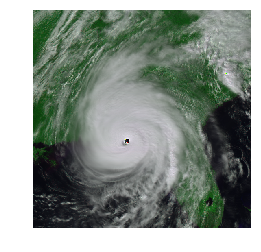

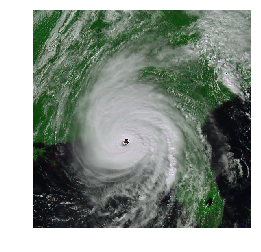

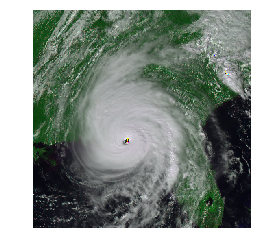

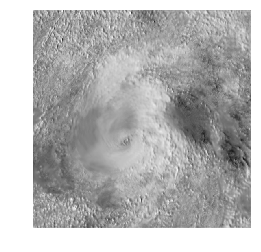

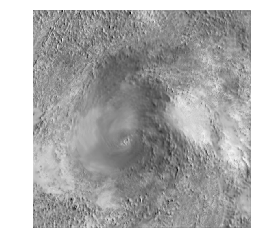

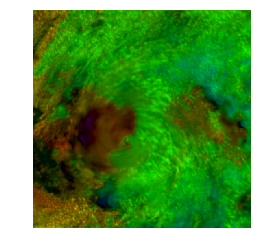

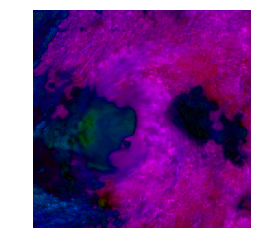

In [25]:
def opticalflow(flow):
    hsv = np.ones((flow.shape[0], flow.shape[1], 3))*255.
    
    # Use Hue, Saturation, Value colour model 
    mag, ang = cv2.cartToPolar(flow[:,:, 0], flow[:,:, 1])
    
    hsv[:,:, 0] = ang * 180 / np.pi / 2
    hsv[:,:, 2] = cv2.normalize(mag, None, 0, 255., cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(np.uint8(hsv), cv2.COLOR_HSV2BGR)
    return bgr

def plot_optical_flow(x, img_file=None):
    x = x.detach().numpy()[0]
    x = np.transpose(x, (1,2,0))
    bgr = opticalflow(x)
    if img_file is not None:
        plt.imsave(img_file, bgr)
    plt.imshow(bgr)
    plt.axis('off')
    plt.show()

    
plot_3channel_image(I_t, os.path.join(figure_directory, 'It.png'))

plot_3channel_image(g0, os.path.join(figure_directory, 'g0.png'))
plot_3channel_image(g1, os.path.join(figure_directory, 'g1.png'))

plot_1channel_image(V_t0, os.path.join(figure_directory, 'V_t0.png'), cmap='Greys')
plot_1channel_image(1-V_t0, os.path.join(figure_directory, 'V_t1.png'), cmap='Greys')

plot_optical_flow(delta_f_t0, os.path.join(figure_directory, 'd_f_t0.png'))
plot_optical_flow(delta_f_t1, os.path.join(figure_directory, 'd_f_t1.png'))